Collaborative Filtering based on Autoencoder
-----



## Introduction
One very common problem to solve is when you have a number of users and a number of products, and you want to recommend which products are most likely to be useful for which users. There are many variations of this: for example, recommending movies (such as on Netflix), figuring out what to highlight for a user on a home page, deciding what stories to show in a social media feed, and so forth. There is a general solution to this problem, called *collaborative filtering*, which works like this: look at what products the current user has used or liked, find other users that have used or liked similar products, and then recommend other products that those users have used or liked.

For example, on Netflix you may have watched lots of movies that are science fiction, full of action, and were made in the 1970s. Netflix may not know these particular properties of the films you have watched, but it will be able to see that other people that have watched the same movies that you watched also tended to watch other movies that are science fiction, full of action, and were made in the 1970s. In other words, to use this approach we don't necessarily need to know anything about the movies, except who like to watch them.

There is actually a more general class of problems that this approach can solve, not necessarily involving users and products. Indeed, for collaborative filtering we more commonly refer to *items*, rather than *products*. Items could be links that people click on, diagnoses that are selected for patients, and so forth.

The key foundational idea is that of *latent factors*. In the Netflix example, we started with the assumption that you like old, action-packed sci-fi movies. But you never actually told Netflix that you like these kinds of movies. And Netflix never actually needed to add columns to its movies table saying which movies are of these types. Still, there must be some underlying concept of sci-fi, action, and movie age, and these concepts must be relevant for at least some people's movie watching decisions.



## Preparations

We first import the packages and download the data.

In [1]:
import torch
torch.cuda.empty_cache()  # Clear GPU cache

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os.path as op
import imp
import numpy as np

from zipfile import ZipFile
try:
    from urllib.request import urlretrieve
except ImportError:  # Python 2 compat
    from urllib import urlretrieve

# this line need to be changed if not on colab:
data_folder = '/content/'


ML_1M_URL = "https://files.grouplens.org/datasets/movielens/ml-32m.zip"
ML_1M_FILENAME = op.join(data_folder,ML_1M_URL.rsplit('/', 1)[1])
ML_1M_FOLDER = op.join(data_folder,'ml-32m')

In [3]:
if not op.exists(ML_1M_FILENAME):
    print('Downloading %s to %s...' % (ML_1M_URL, ML_1M_FILENAME))
    urlretrieve(ML_1M_URL, ML_1M_FILENAME)

if not op.exists(ML_1M_FOLDER):
    print('Extracting %s to %s...' % (ML_1M_FILENAME, ML_1M_FOLDER))
    ZipFile(ML_1M_FILENAME).extractall(data_folder)

Extracting /content/ml-32m.zip to /content/ml-32m...


There are four different files:

- README
- movies.dat
- ratings.dat
- users.dat

You may read README to get the description of each dat files.

## Check the data

In [4]:
import os

# Path to the extracted dataset folder
dataset_path = '/content/ml-32m'  # Adjust this path if needed

# List all files in the folder
files = os.listdir(dataset_path)
print("Files in the dataset:")
for file in files:
    print(file)


Files in the dataset:
ratings.csv
tags.csv
checksums.txt
links.csv
README.txt
movies.csv


In [5]:
import pandas as pd

ratings = pd.read_csv('/content/ml-32m/ratings.csv')
print(ratings.head())


   userId  movieId  rating  timestamp
0       1       17     4.0  944249077
1       1       25     1.0  944250228
2       1       29     2.0  943230976
3       1       30     5.0  944249077
4       1       32     5.0  943228858


In [6]:
movies = pd.read_csv('/content/ml-32m/movies.csv')
print(movies.head())

   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


When showing the data, we would rather see movie titles than their IDs. The `movies.csv` contains the correspondence of IDs to movie titles.

In [7]:


# Ensure `movieId` in both datasets is of the same type
ratings['movieId'] = ratings['movieId'].astype(int)
movies['movieId'] = movies['movieId'].astype(int)

# Merge the ratings and movies datasets on the common column 'movieId'
all_ratings = ratings.merge(movies, on='movieId')

# Preview the merged data
print(all_ratings.head())


   userId  movieId  rating  timestamp  \
0       1       17     4.0  944249077   
1       1       25     1.0  944250228   
2       1       29     2.0  943230976   
3       1       30     5.0  944249077   
4       1       32     5.0  943228858   

                                               title  \
0                       Sense and Sensibility (1995)   
1                           Leaving Las Vegas (1995)   
2  City of Lost Children, The (Cité des enfants p...   
3  Shanghai Triad (Yao a yao yao dao waipo qiao) ...   
4          Twelve Monkeys (a.k.a. 12 Monkeys) (1995)   

                                   genres  
0                           Drama|Romance  
1                           Drama|Romance  
2  Adventure|Drama|Fantasy|Mystery|Sci-Fi  
3                             Crime|Drama  
4                 Mystery|Sci-Fi|Thriller  


Here we add the title of the movies to the `all_ratings` data.

The dataframe `all_ratings` contains all the raw data for our problem.

In [8]:
#number of entries
len(all_ratings)

32000204

# Subseting

Because of limited coputing power, we need to downsample the dataset to make the code more manageable.

Here we use timestamp as a cutoff point to filter the ratinsg after 2021.

In [9]:

# Define the cutoff UNIX timestamp for January 1, 2022
cutoff_timestamp_2022 = 1640995200

# Filter the dataset for data after 2021
data = all_ratings[all_ratings['timestamp'] >= cutoff_timestamp_2022].copy()

# Extract year from timestamp and add as a new column
data['year'] = pd.to_datetime(data['timestamp'], unit='s').dt.year

# Perform random sampling for each year (50% of data per year)
new_data = data.groupby('year').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)

# Count the number of records after sampling
num_records_sampled = len(new_data)

# Print the number of records and preview the sampled data
print(f"Number of records after random sampling: {num_records_sampled}")
print(new_data.head())



Number of records after random sampling: 170715
   userId  movieId  rating   timestamp                     title  \
0  102721     7438     0.5  1672470668  Kill Bill: Vol. 2 (2004)   
1  166762   199223     4.5  1642568062       Pet Sematary (2019)   
2   60048     4091     5.0  1654186782  Can't Buy Me Love (1987)   
3  200028    79132     4.5  1641004269          Inception (2010)   
4  141385    54503     4.5  1663266119           Superbad (2007)   

                                            genres  year  
0                            Action|Drama|Thriller  2022  
1                                  Horror|Thriller  2022  
2                                   Comedy|Romance  2022  
3  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX  2022  
4                                           Comedy  2022  


<ipython-input-9-bf82532bfc35>:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  new_data = data.groupby('year').apply(lambda x: x.sample(frac=0.1, random_state=42)).reset_index(drop=True)


In [10]:
# Statistics of ratings
ratings_stats = new_data['rating'].describe()
print(ratings_stats)


count    170715.000000
mean          3.530158
std           1.062323
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64


In [11]:
# Find unique ratings
unique_ratings = new_data['rating'].unique()
print("Unique ratings:", unique_ratings)


Unique ratings: [0.5 4.5 5.  3.  4.  2.  3.5 2.5 1.5 1. ]


We now check the user IDs.

In [12]:
# Statistics for the userId column
user_stats = new_data['userId'].describe()
print(user_stats)


count    170715.000000
mean     100911.723446
std       58418.321408
min          22.000000
25%       49923.000000
50%      101154.000000
75%      152179.000000
max      200933.000000
Name: userId, dtype: float64


In [13]:
# Calculate the number of unique users
total_user_id = len(new_data['userId'].unique())
print("Total number of unique users:", total_user_id)


Total number of unique users: 12561


 Let's check that whether the users are indexed from 0 below using the following code.


In [14]:
# Create a sorted list of unique user IDs
list_user_id = list(new_data['userId'].unique())
list_user_id.sort()

# Preview the sorted list (optional)
print("Sorted list of user IDs:", list_user_id[:10])  # Display the first 10 user IDs


Sorted list of user IDs: [22, 25, 28, 31, 58, 75, 79, 94, 101, 110]


We can see that `list_user_id` contains contiguous indices from 22.

We create a new column `user_num` to get an index from 0 to  for users:

In [15]:

# Map user IDs to indices starting from 0
user_id_to_index = {user_id: index for index, user_id in enumerate(list_user_id)}

# Add the new column `user_num` to the ratings DataFrame
new_data['user_num'] = new_data['userId'].map(user_id_to_index)


We now look at movies.

In [16]:
# Find unique movies
unique_movies = new_data['movieId'].unique()
print("Unique movies:", len(unique_movies))


Unique movies: 18554


Here there is a clear problem: there are 84432 different movies but the range of `item_id` starts at 1 and ends at 32,000,200. So there are gaps, so the first thing you will need to do is to create a new column `item_num` so that all movies are indexed from 0 to 84431.

In [17]:
# Create a sorted list of unique user IDs
list_movie_id = list(new_data['movieId'].unique())
list_movie_id.sort()

# Preview the sorted list (optional)
print(list_movie_id[:10])  # First 10 values
print(list_movie_id[-10:]) # Last 10 values


[1, 2, 3, 4, 5, 6, 7, 9, 10, 11]
[292009, 292093, 292141, 292185, 292229, 292349, 292365, 292585, 292597, 292755]


We can see that `list_movie_id` contains contiguous indices from 1, and there are gaps somewhere.

We create a new column `movie_num` to get an index from 0, and make sure it is increased by 1.

In [18]:

# Map movie IDs to indices starting from 0
movie_id_to_index = {movie_id: index for index, movie_id in enumerate(list_movie_id)}

# Add the new column `movie_num` to the ratings DataFrame
new_data['movie_num'] = new_data['movieId'].map(movie_id_to_index)

This function will verify that we have created `movie_num` correctly.

In [19]:
# Function to verify the `movie_num` column is correctly created
def check_ratings_num(df):
    movie_num = set(df['movie_num'])
    if movie_num == set(range(len(movie_num))):
        return True
    else:
        return False

In [20]:
# Apply the function to the DataFrame
result = check_ratings_num(new_data)
print("Verification result:", result)


Verification result: True


Let's check the dataset:

In [21]:

# Preview the updated DataFrame
print(new_data.head())


   userId  movieId  rating   timestamp                     title  \
0  102721     7438     0.5  1672470668  Kill Bill: Vol. 2 (2004)   
1  166762   199223     4.5  1642568062       Pet Sematary (2019)   
2   60048     4091     5.0  1654186782  Can't Buy Me Love (1987)   
3  200028    79132     4.5  1641004269          Inception (2010)   
4  141385    54503     4.5  1663266119           Superbad (2007)   

                                            genres  year  user_num  movie_num  
0                            Action|Drama|Thriller  2022      6431       4138  
1                                  Horror|Thriller  2022     10384      14052  
2                                   Comedy|Romance  2022      3724       2486  
3  Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX  2022     12497       7473  
4                                           Comedy  2022      8810       6238  


Now, we are using 'new_data' as our raw dataset to build our network.

### Exploratory analysis

In [22]:
# Describe the movieId column in all_ratings
movie_stats = new_data['movie_num'].describe()
print(movie_stats)


count    170715.000000
mean       7226.297180
std        5241.942127
min           0.000000
25%        2551.000000
50%        6563.000000
75%       10822.000000
max       18553.000000
Name: movie_num, dtype: float64


In [23]:
# Number of unique rated items
total_item_id = len(new_data['movieId'].unique())
print("Total number of unique rated items:", total_item_id)


Total number of unique rated items: 18554


### Preliminary data analysis

Top 10 most popular movies in the dataset.

In [24]:
# Find the top 10 most frequently rated movies
top_movies = new_data['title'].value_counts().nlargest(10)
print(top_movies)


title
Interstellar (2014)                                          489
Inception (2010)                                             482
Matrix, The (1999)                                           462
Fight Club (1999)                                            457
Dark Knight, The (2008)                                      457
Shawshank Redemption, The (1994)                             429
Lord of the Rings: The Return of the King, The (2003)        421
Lord of the Rings: The Fellowship of the Ring, The (2001)    415
Everything Everywhere All at Once (2022)                     408
Dune (2021)                                                  402
Name: count, dtype: int64


 Plot the histogram of popularity (x-axis: # of given ratings, y-axis: # of movies with the given # of ratings).

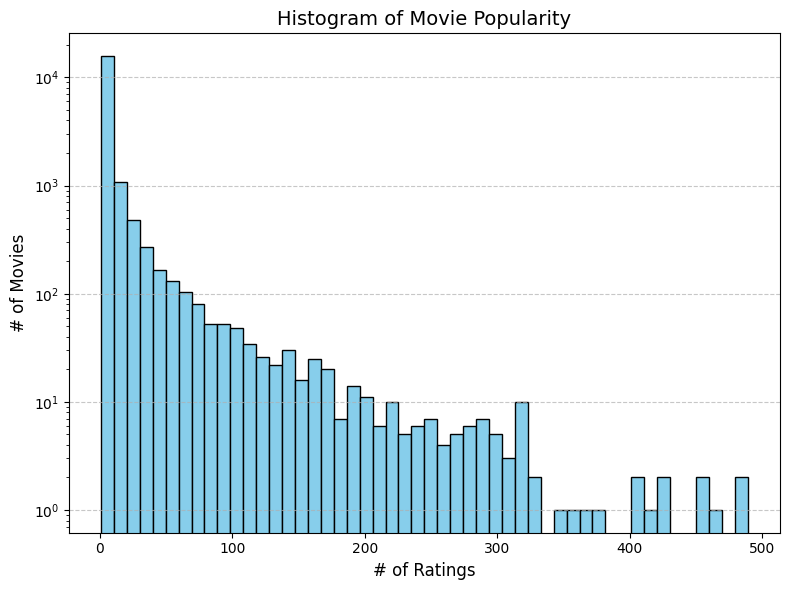

In [25]:
import matplotlib.pyplot as plt

# Calculate the number of ratings per movie
ratings_per_movie = new_data['title'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings_per_movie, bins=50, color='skyblue', edgecolor='black', log=True)

# Add labels and title
plt.title('Histogram of Movie Popularity', fontsize=14)
plt.xlabel('# of Ratings', fontsize=12)
plt.ylabel('# of Movies', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Plot the histogram of user activity (x-axis: # of given ratings, y-axis: # of users with the given # of ratings).

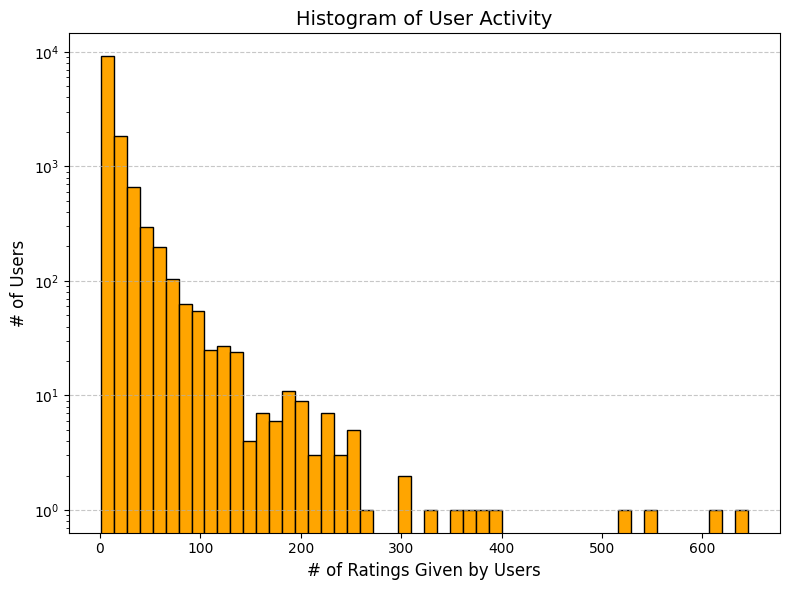

In [26]:

# Calculate the number of ratings per user
ratings_per_user = new_data['userId'].value_counts()

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(ratings_per_user, bins=50, color='orange', edgecolor='black', log=True)

# Add labels and title
plt.title('Histogram of User Activity', fontsize=14)
plt.xlabel('# of Ratings Given by Users', fontsize=12)
plt.ylabel('# of Users', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()


Let's check the distribution of the movies.

Firstly, we need to check if all rows contain 'year' information:

In [27]:

# Check if the title column contains a year in parentheses
new_data['has_year'] = new_data['title'].str.contains(r'\(\d{4}\)', regex=True)

# Identify titles missing the year
missing_year_titles = new_data[~new_data['has_year']]

# Output the result
if missing_year_titles.empty:
    print("All titles include a bracket containing year information.")
else:
    print("The following titles are missing year information:")
    print(missing_year_titles[['title']])


The following titles are missing year information:
                          title
310               The Favourite
591                   Moonlight
599                Petrov's Flu
696                The Northman
840     The Woman in the Window
...                         ...
170423            The Favourite
170519             The Northman
170637                Moonlight
170641             The Northman
170683                      Tau

[1001 rows x 1 columns]


Count how many movies are missing their 'year' information:

In [28]:
# Step 1: Filter rows where the title is missing year information
missing_year_titles = new_data[~new_data['has_year']]

# Step 2: Count unique movies (titles) missing year information
unique_missing_titles_count = missing_year_titles['title'].nunique()

# Output the result
print(f"There are {unique_missing_titles_count} unique movies missing year information.")


There are 83 unique movies missing year information.


Considering that we have around 51k unique movies in this dataset, we can just ignore the missing information and generate a distribution plot of the rest movies.

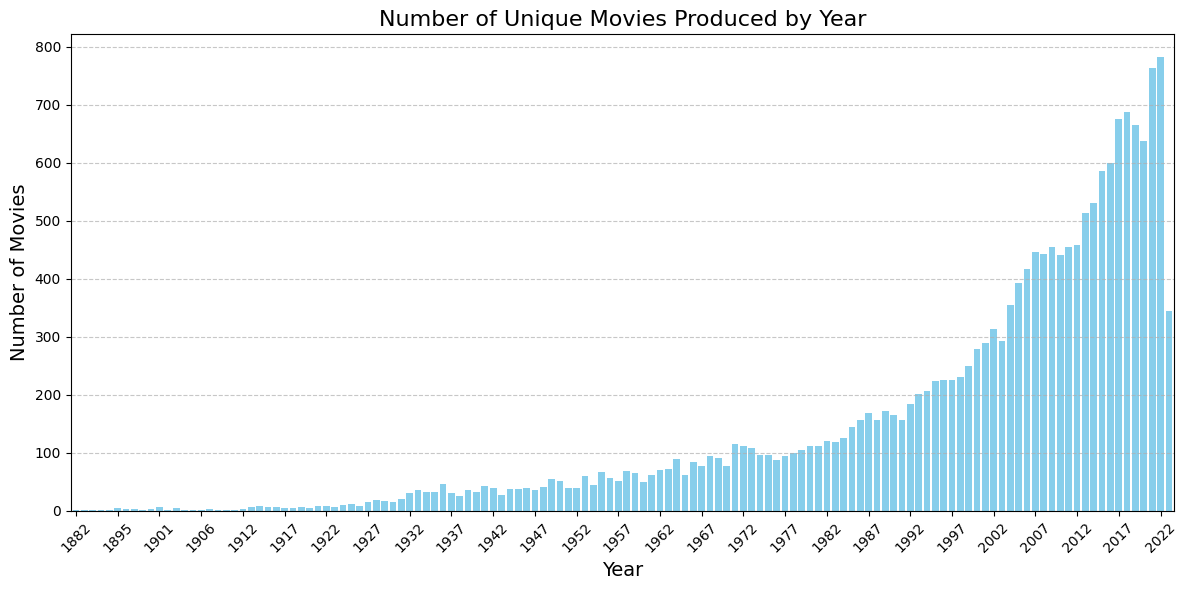

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Filter rows with valid year information
new_data_with_year = new_data[new_data['has_year']].copy()

# Step 2: Extract the year from the title column
new_data_with_year['year'] = new_data_with_year['title'].str.extract(r'\((\d{4})\)')

# Step 3: Remove duplicates based on the title column
unique_movies = new_data_with_year.drop_duplicates(subset='title')

# Step 4: Count the number of unique movies produced each year
movies_per_year = unique_movies['year'].value_counts().sort_index()

# Step 5: Plot the histogram of unique movies by year
plt.figure(figsize=(12, 6))
movies_per_year.plot(kind='bar', width=0.8, color='skyblue')

# Set x-axis labels to display every 5 years
plt.title('Number of Unique Movies Produced by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Movies', fontsize=14)
plt.xticks(range(0, len(movies_per_year), 5), movies_per_year.index[::5], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


**Exercise**: Compute the average ratings for every movie and find the top 20 highly rated movies. Include the list of 20 highly rated movies and their ratings in your report.

In [30]:

# Compute the average rating for each movie
movie_avg_ratings = new_data.groupby('title')['rating'].mean()

# Sort the movies by their average ratings in descending order
top_50_movies = movie_avg_ratings.sort_values(ascending=False).head(50)

# Print the results
print("Top 50 Highly Rated Movies:")
print(top_50_movies)


Top 50 Highly Rated Movies:
title
The Greasy Strangler (2016)                                                 5.0
Your Name Engraved Herein (2020)                                            5.0
Summer Survivors (2018)                                                     5.0
Cook Up a Storm (2017)                                                      5.0
Who Killed Captain Alex? (2010)                                             5.0
Moomin and Midsummer Madness (2008)                                         5.0
Chris D'Elia: Man on Fire (2017)                                            5.0
Tomorrow (2015)                                                             5.0
The High Note (2020)                                                        5.0
Random Acts of Christmas (2019)                                             5.0
Those Happy Days (2006)                                                     5.0
Christina P: Mother Inferior (2017)                                         5.0
Mother

We see that some highly rated movies are not popular ones.

# Autoencoder




**Step1：Matrix Operations**

This step ensures that the interaction matrix is correctly set up and ready for computations on the GPU.

In [31]:
from sklearn.model_selection import train_test_split

# Split the dataset into training (80%) and validation (20%) sets
train_data, validation_data = train_test_split(new_data, test_size=0.2, random_state=42)

# Verify the number of records in each set
print(f"Training Set Records: {len(train_data)}")
print(f"Validation Set Records: {len(validation_data)}")


Training Set Records: 136572
Validation Set Records: 34143


In [32]:
# Ensure both matrices have the same set of columns
common_items = list(set(train_data['movie_num']).intersection(set(validation_data['movie_num'])))

# Filter training and validation data to include only common items
train_data = train_data[train_data['movie_num'].isin(common_items)]
validation_data = validation_data[validation_data['movie_num'].isin(common_items)]

# Create user-item matrices for training and validation
train_user_item_matrix = train_data.pivot(index='user_num', columns='movie_num', values='rating').fillna(0)
validation_user_item_matrix = validation_data.pivot(index='user_num', columns='movie_num', values='rating').fillna(0)

# Ensure the same column order for both matrices
train_user_item_matrix = train_user_item_matrix[common_items]
validation_user_item_matrix = validation_user_item_matrix[common_items]

# Convert to NumPy arrays for GPU processing
train_interaction_matrix = train_user_item_matrix.to_numpy()
validation_interaction_matrix = validation_user_item_matrix.to_numpy()

print(f"Training Matrix Shape: {train_interaction_matrix.shape}")
print(f"Validation Matrix Shape: {validation_interaction_matrix.shape}")


Training Matrix Shape: (12025, 6238)
Validation Matrix Shape: (8679, 6238)


In [33]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [34]:

# Convert interaction matrices to PyTorch tensors
train_tensor = torch.tensor(train_interaction_matrix, dtype=torch.float32).to(device)
validation_tensor = torch.tensor(validation_interaction_matrix, dtype=torch.float32).to(device)

print(f"Training Tensor Device: {train_tensor.device}")
print(f"Validation Tensor Device: {validation_tensor.device}")


Training Tensor Device: cuda:0
Validation Tensor Device: cuda:0


**Step 2: Define AutoRec Model**

The AutoRec model consists of an encoder-decoder structure with dropout and ReLU activation.

In [35]:
class AutoRec(torch.nn.Module):
    def __init__(self, num_items, hidden_dim=500, dropout_rate=0.2):
        super(AutoRec, self).__init__()
        self.encoder = torch.nn.Linear(num_items, hidden_dim)
        self.decoder = torch.nn.Linear(hidden_dim, num_items)
        self.dropout = torch.nn.Dropout(dropout_rate)
        self.activation = torch.nn.ReLU()

    def forward(self, x):
        x = self.encoder(x)  # Latent representation
        x = self.activation(x)  # Non-linearity
        x = self.dropout(x)  # Regularization
        x = self.decoder(x)  # Reconstruction
        return x

# Initialize the model
num_items = train_interaction_matrix.shape[1] # Number of items (columns) from the training tensor
hidden_dim = 300
dropout_rate = 0.5

# Create the AutoRec model
model = AutoRec(num_items, hidden_dim, dropout_rate).to(device)
print("AutoRec model reinitialized with aligned item dimensions.")


AutoRec model reinitialized with aligned item dimensions.


**Step 3: Define Loss Function and Optimizer**

In [36]:
# Define the loss function and optimizer
loss_fn = torch.nn.MSELoss()  # Mean Squared Error for reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer
print("Loss function and optimizer are set up.")


Loss function and optimizer are set up.


**Step 4: Training Loop**

Train the model over multiple epochs, and store the loss for plotting later.

In [37]:
import torch
import numpy as np

# Define training parameters
num_epochs = 50
batch_size = 128
patience = 7  # Stop training if validation loss doesn't improve for 7 epochs
patience_counter = 0
best_val_loss = float("inf")

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)  # Added weight decay

train_losses = []
val_losses = []

num_users = train_tensor.shape[0]

# Training loop with early stopping
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for i in range(0, num_users, batch_size):
        batch_data = train_tensor[i:i + batch_size]

        optimizer.zero_grad()
        reconstructed = model(batch_data)

        mask = batch_data > 0  # Only consider non-zero ratings
        loss = loss_fn(reconstructed[mask], batch_data[mask])

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / (num_users // batch_size)
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {avg_train_loss:.4f}")

    # Validation loss computation
    model.eval()
    with torch.no_grad():
        reconstructed_val = model(validation_tensor)
        mask_val = validation_tensor > 0
        val_loss = loss_fn(reconstructed_val[mask_val], validation_tensor[mask_val]).item()
        val_losses.append(val_loss)

    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0  # Reset patience counter
    else:
        patience_counter += 1  # Increase patience counter

    if patience_counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break


Epoch 1/50, Training Loss: 13.7933
Validation Loss: 13.2279
Epoch 2/50, Training Loss: 11.1489
Validation Loss: 11.3446
Epoch 3/50, Training Loss: 7.1964
Validation Loss: 9.5857
Epoch 4/50, Training Loss: 5.8415
Validation Loss: 8.9078
Epoch 5/50, Training Loss: 5.1103
Validation Loss: 8.4214
Epoch 6/50, Training Loss: 4.5945
Validation Loss: 7.9877
Epoch 7/50, Training Loss: 4.1605
Validation Loss: 7.5667
Epoch 8/50, Training Loss: 3.8336
Validation Loss: 7.2289
Epoch 9/50, Training Loss: 3.5467
Validation Loss: 6.8940
Epoch 10/50, Training Loss: 3.2943
Validation Loss: 6.5583
Epoch 11/50, Training Loss: 3.0667
Validation Loss: 6.2709
Epoch 12/50, Training Loss: 2.8799
Validation Loss: 5.9858
Epoch 13/50, Training Loss: 2.6848
Validation Loss: 5.6945
Epoch 14/50, Training Loss: 2.5214
Validation Loss: 5.4474
Epoch 15/50, Training Loss: 2.3846
Validation Loss: 5.2059
Epoch 16/50, Training Loss: 2.2351
Validation Loss: 4.9611
Epoch 17/50, Training Loss: 2.0950
Validation Loss: 4.7388
Ep

Evaluate the reconstruction error on the training data using RMSE.

In [38]:
import math

# Evaluate model performance
model.eval()
with torch.no_grad():
    reconstructed_train = model(train_tensor)
    mask_train = train_tensor > 0
    mse_train = loss_fn(reconstructed_train[mask_train], train_tensor[mask_train])
    rmse_train = math.sqrt(mse_train.item())

    reconstructed_validation = model(validation_tensor)
    mask_val = validation_tensor > 0
    mse_val = loss_fn(reconstructed_validation[mask_val], validation_tensor[mask_val])
    rmse_val = math.sqrt(mse_val.item())

print(f"Final RMSE on Training Data: {rmse_train:.4f}")
print(f"Final RMSE on Validation Data: {rmse_val:.4f}")


Final RMSE on Training Data: 0.6088
Final RMSE on Validation Data: 1.1836


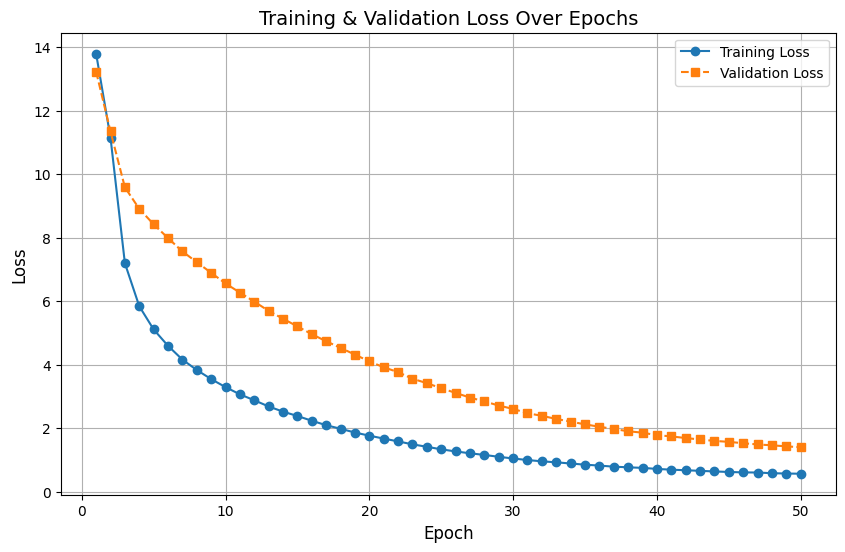

In [39]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', linestyle='dashed', label='Validation Loss')

plt.title('Training & Validation Loss Over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


Visualize the loss over epochs to monitor the training process.